# Tarea 3: Recomendación (Modelo para predicción de compra)

<a href="https://github.com/carlosperez1997/proyecto_easyMoney/blob/main/README.md" target="_blank">Volver a Página Principal</a>

Parte de la solución de la <a href="./tarea3_recomendacion.ipynb">Tarea 3: Recomendación</a> está en crear un modelo que permita obtener una probabilidad de cuáles recomendaciones de la parte anterior tienen mayor probabilidad de éxito con el fin de poder escoger entre la larga lista de recomendaciones reduciendo así el riesgo y optando por las opciones de las que estamos más seguros. 

Este modelo se trata de un modelo de Machine Learning supervisado de clasificación binaria, donde 1 o True significa que ha comprado y 0 que no ha comprado. Se desarrolla 1 modelo general aunque se prueban 3 modelos para cada tipo de producto.
Durante el desarrollo de este notebook se irán preparando y limpiando los datos del modelo para finalmente obtener un modelo muy aceptable con un ROC AUC score de 0.89. 

Para simplificar el problema se considera como compra si un cliente se da de alta en ese producto. Sin embargo, como se comenta en tareas anteriores este no es el caso y el producto no se cobra hasta pasados 3 meses de permanencia. Tener en cuenta el cumplimiento de la permanencia para el modelo hubiera sido otro problema muy distinto y bastante más complejo. 

## Tabla de Contenidos <a class="anchor" id="0"></a>

1. [Data Preparation](#1) <br>
    1.1 [Determinar altas](#11) <br>
    1.2 [Codificar variables de texto](#12) <br>
    1.3 [Altas y bajas en los últimos meses](#13) <br>
    1.4 [Tiempo desde la última compra](#14) <br>
    1.5 [Tramificación de variables numéricas](#15) <br>
    1.6 [Feature Generator](#16) <br>
    1.7 [Preparación del target](#17) <br>
    1.8 [Precio del producto a comprar](#18) <br>
    1.9 [Preparación de la predicción](#19) <br>
2. [Data Cleaning](#2) <br>
    2.1 [Preparación de la predicción](#21) <br>
3. [Model Construction](#3) <br>
    3.1. [Modelo General](#31) <br>
    3.2. [Modelo Cuentas](#32) <br>
    3.3. [Modelo Ahorros](#33) <br>
    3.4. [Modelo Financiación](#34) <br>
    3.5. [Selección del modelo](#35) <br>
4. [Conclusiones](#4) <br>

**Importación de librerías y dataset**



In [1]:
!pip install graphviz

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

PREPARE_PREDICTION = False

In [3]:
DIR_PATH = '/Users/carlosperezricardo/Documents/data/'
DIR_PATH = '../input/easymoneygrupo5/'

commercial_activity = pd.read_csv(DIR_PATH+'commercial_activity_df.csv', encoding='utf-8')
commercial_activity.drop(columns=['Unnamed: 0'], inplace=True)

products = pd.read_csv(DIR_PATH+'products_df.csv', encoding='utf-8')
products.drop(columns=['Unnamed: 0'], inplace=True)

sociodemographic = pd.read_csv(DIR_PATH+'sociodemographic_df.csv', encoding='utf-8')
sociodemographic.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
df_whole = pd.merge( commercial_activity, products, on = ['pk_cid','pk_partition'] )
df_whole = pd.merge( df_whole, sociodemographic, on=['pk_cid','pk_partition'] )

In [5]:
boolean_cols = ["short_term_deposit", "loans", "mortgage", "funds", "securities","long_term_deposit", "em_account_pp", \
                "credit_card", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "payroll", "pension_plan"] 

for x in boolean_cols:
    df_whole[x] = df_whole[x].astype(bool)

In [6]:
df_whole.head(3).T

,0,1,2
pk_cid,1375586,1050611,1050612
pk_partition,2018-01-28,2018-01-28,2018-01-28
entry_date,2018-01-12,2015-08-10,2015-08-10
entry_channel,KHL,KHE,KHE
active_customer,1.0,0.0,0.0
segment,02 - PARTICULARES,03 - UNIVERSITARIO,03 - UNIVERSITARIO
short_term_deposit,False,False,False
loans,False,False,False
mortgage,False,False,False
funds,False,False,False


In [7]:
del commercial_activity, products, sociodemographic

In [8]:
partitions = ['2018-01-28','2018-02-28','2018-03-28','2018-04-28','2018-05-28','2018-06-28', \
    '2018-07-28','2018-08-28','2018-09-28','2018-10-28','2018-11-28','2018-12-28','2019-01-28', \
        '2019-02-28','2019-03-28','2019-04-28','2019-05-28']

list_products = ['short_term_deposit','loans','mortgage','funds','securities',
    'long_term_deposit','em_account_pp','credit_card','pension_plan',
    'payroll_account','emc_account','debit_card','em_account_p','em_acount']

products_dict = {"short_term_deposit":"ahorro e inversión", "loans":"financiación", "mortgage":"financiación", 
    "funds":"ahorro e inversión", "securities":"ahorro e inversión", "long_term_deposit":"ahorro e inversión", 
    "em_account_pp":"cuenta", "credit_card":"financiación", "payroll_account":"cuenta", "pension_plan":"ahorro e inversión", 
    "emc_account":"cuenta", "debit_card":"financiación", "em_account_p":"cuenta", "em_acount":"cuenta"}

cost_product = {'cuenta':10, 'ahorro e inversión':40, 'financiación':60}

# Data Preparation <a class="anchor" id="1"></a>
## Determinar altas y bajas <a class="anchor" id="11"></a>

[Tabla de Contenidos](#0)

En esta subtarea es importante detectar las altas de productos. La función implementada es la misma que para la <a href="https://www.amazon.es/Hands-Unsupervised-Learning-Using-Python/dp/1492035645">Tarea 2: Segmentación **PONER LINK BIEN!!!**</a>. Las altas será nuestro target a predecir. Dado que queremos predecir cuando un usuario se da de alta o no, se contabiliza el estado de todos los productos en esa partición por cada cliente. Finalmente, la columna total indica 1 o mayor que 1, si un cliente se dio de alta en cualquier producto durante ese mes, o 0 si no se dio de alta. 

In [9]:
def determinar_altas(data):
    data.columns=['pk_partition','pk_cid','product']
    data['prev'] = data.groupby('pk_cid')['product'].shift(1)
    data['diff'] = data['product'] - data['prev']

    # Solo queremos 1 
    data['diff'] = np.where( (data['product']==1) & (data['diff'].isna()) & (data['pk_partition']!='2018-01-28'), 1, data['diff'] )
    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == -1, 0, data['diff'] )

    return data['diff']

In [10]:
def determinar_bajas(data):
    data.columns=['pk_partition','pk_cid','product']
    data['prev'] = data.groupby('pk_cid')['product'].shift(1)
    data['diff'] = data['product'] - data['prev']

    # Solo queremos -1 pero los codificamos como 1 (más facil) 
    data['diff'] = np.where( (data['product']==1) & (data['diff'].isna()) & (data['pk_partition']!='2018-01-28'), 1, data['diff'] )
    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == 0, 0, data['diff'] )
    data['diff'] = np.where( data['diff'] == -1, 1, data['diff'] )

    return data['diff']

In [11]:
df = df_whole.copy(deep=True)

In [12]:
for prod in list_products:
    df[prod+'_altas'] = determinar_altas( df_whole[['pk_partition','pk_cid',prod]] )
    df[prod+'_bajas'] = determinar_bajas( df_whole[['pk_partition','pk_cid',prod]] )
    print(prod)

short_term_deposit
loans
mortgage
funds
securities
long_term_deposit
em_account_pp
credit_card
pension_plan
payroll_account
emc_account
debit_card
em_account_p
em_acount


In [13]:
# Total altas
products_dict2 = {"short_term_deposit":"ahorros", "loans":"financiacion", "mortgage":"financiacion", 
    "funds":"ahorros", "securities":"ahorros", "long_term_deposit":"ahorros", 
    "em_account_pp":"cuenta", "credit_card":"financiacion", "payroll_account":"cuenta", "pension_plan":"ahorros", 
    "emc_account":"cuenta", "debit_card":"financiacion", "em_account_p":"cuenta", "em_acount":"cuenta"}

init_cols = ['total_altas_cuenta','total_altas_ahorros','total_altas_financiacion',
    'altas_cuenta','altas_ahorros','altas_financiacion',
    'total_bajas_cuenta','total_bajas_ahorros','total_bajas_financiacion'] 

for col in init_cols:
    df[col] = 0

for key, value in products_dict2.items():
    df['total_altas_'+value] += df[key+'_altas']
    df['altas_'+value] +=  df['total_altas_'+value]
    df['total_bajas_'+value] += df[key+'_bajas'] 
    
    # memory optimization
    df['altas_'+value] = df['total_altas_'+value].astype('int8')
    df['total_altas_'+value] = df['total_altas_'+value].astype('int8')
    df['total_altas_'+value] = df['total_bajas_'+value].astype('int8')
    
    df.drop([key+'_bajas',key+'_altas'], axis=1, inplace=True)

df['total_altas'] = df['total_altas_cuenta'] + df['total_altas_ahorros'] + df['total_altas_financiacion']
df['total_bajas'] = df['total_bajas_cuenta'] + df['total_bajas_ahorros'] + df['total_bajas_financiacion']

In [14]:
df['total'] = df['altas_cuenta'] + df['altas_ahorros'] + df['altas_financiacion']

In [15]:
df = df.sort_values(['pk_cid','pk_partition'])
df.head(3).T

,1479563,2168122,2962973
pk_cid,15891,15891,16063
pk_partition,2018-07-28,2018-08-28,2018-11-28
entry_date,2018-07-28,2018-07-28,2018-11-19
entry_channel,KAT,KAT,KAT
active_customer,1.0,0.0,1.0
segment,NaN,02 - PARTICULARES,NaN
short_term_deposit,False,False,False
loans,False,False,False
mortgage,False,False,False
funds,False,False,False


In [16]:
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 1479563 to 5679912
Data columns (total 39 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   pk_cid                    int64         
 1   pk_partition              datetime64[ns]
 2   entry_date                object        
 3   entry_channel             object        
 4   active_customer           float64       
 5   segment                   object        
 6   short_term_deposit        bool          
 7   loans                     bool          
 8   mortgage                  bool          
 9   funds                     bool          
 10  securities                bool          
 11  long_term_deposit         bool          
 12  em_account_pp             bool          
 13  credit_card               bool          
 14  payroll                   bool          
 15  pension_plan              bool          
 16  payroll_account           bool          
 17  em

## Codificar variables de texto <a class="anchor" id="12"></a>

[Tabla de Contenidos](#0)

A continuación pasamos a valor numérico los campos de entry_channel y gender con un LabelEncoder.

In [18]:
le = LabelEncoder()
le.fit(df['entry_channel'])
df['entry_channel'] = le.transform(df['entry_channel'])

In [19]:
le = LabelEncoder()
le.fit(df['gender'])
df['gender'] = le.transform(df['gender'])

In [20]:
del le

## Altas y bajas en los últimos meses <a class="anchor" id="13"></a>

[Tabla de Contenidos](#0)

En esta sección se determinan las altas y bajas en los últimos. Para ello se utiliza la función rolling que permite hacer un resumeen (max, mean, min...) de los meses que se indiquen. Para la predicción no se realiza el último shift. 


In [21]:
def rolling_shift(df, col, window, calc):
    if calc == 'sum':
        rolling = df.groupby('pk_cid')[[col]].rolling(window = window, min_periods=1).sum()
    elif calc == 'max':
        rolling = df.groupby('pk_cid')[[col]].rolling(window = window, min_periods=1).max()
    
    rolling.reset_index(inplace=True)
    #rolling['shift'] = rolling.groupby('pk_cid')[[col]].shift(1)
    rolling[col].fillna(0,inplace=True)
    rolling[col] = rolling[col].astype('int')
        
    return rolling[col]

In [22]:
bajas_shifts = []

transf = {'1m':1,'3m':3}
cols = ['total_bajas','total_bajas_cuenta','total_bajas_ahorros','total_bajas_financiacion']

for total in cols:
    for key, window in transf.items():
        if window == 1:
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
        else:
            df[total] = rolling_shift(df, total, window, 'sum')
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
            
        df[total+'_'+key+'_shift'].fillna(0, inplace=True)
        df[total+'_'+key+'_shift'] = df[total+'_'+key+'_shift'].astype('int8')
    
        bajas_shifts.append(total+'_'+key+'_shift')
        
    print(total)
    df.drop(total, axis=1, inplace=True)

total_bajas
total_bajas_cuenta
total_bajas_ahorros
total_bajas_financiacion


In [23]:
altas_shifts = []

transf = {'1m':1,'2m':2,'3m':3,'6m':6}
cols = ['total_altas','total_altas_cuenta','total_altas_ahorros','total_altas_financiacion']

for total in cols:
    for key, window in transf.items():
        if window == 1:
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
        else:
            df[total] = rolling_shift(df, total, window, 'sum')
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
            
        df[total+'_'+key+'_shift'].fillna(0, inplace=True)
        df[total+'_'+key+'_shift'] = df[total+'_'+key+'_shift'].astype('int8')
        
        altas_shifts.append(total+'_'+key+'_shift')

    print(total)
    df.drop(total, axis=1, inplace=True)

total_altas
total_altas_cuenta
total_altas_ahorros
total_altas_financiacion


In [24]:
df['cuentas_fans'] = np.where( (df['total_altas_cuenta_3m_shift'] >= 1), 1, 0 )
df['cuentas_fans'] = np.where( (df['total_altas_cuenta_3m_shift'] >= 2), 2, df['cuentas_fans'] )
df['cuentas_fans'] = np.where( df['total_altas_cuenta_3m_shift'] >= 3, 3, df['cuentas_fans'] )
print(df['cuentas_fans'].value_counts())

df['ahorros_fans'] = np.where( df['total_altas_ahorros_3m_shift'] > 1, 1, 0 )
print(df['ahorros_fans'].value_counts())

df['financiacion_fans'] = np.where( df['total_altas_financiacion_3m_shift'] > 1, 1, 0 )
print(df['financiacion_fans'].value_counts())

df['fans'] = np.where( df['total_altas_3m_shift'] >= 1, 1, 0 )
df['fans'] = np.where( df['total_altas_3m_shift'] >= 2, 2, df['fans'] )
df['fans'] = np.where( df['total_altas_3m_shift'] >= 3, 3, df['fans'] )
print(df['fans'].value_counts())

0    5202708
1     531564
2     196608
3      32044
Name: cuentas_fans, dtype: int64
0    5882766
1      80158
Name: ahorros_fans, dtype: int64
0    5787002
1     175922
Name: financiacion_fans, dtype: int64
0    4521648
1     859675
2     381605
3     199996
Name: fans, dtype: int64


## Tiempo desde la última compra <a class="anchor" id="14"></a>

[Tabla de Contenidos](#0)

Como es de esperar un mismo cliente no tiene el mismo comportamiento cada mes, es decir no realiza una compra cada mes sino que realiza una compra (se da de alta) un mes y lo vuelve a hacer dentro de 3 meses, por ejemplo. Una métrica interesante a obtener es el tiempo que ha transcurrido desde su última compra. 

El siguiente código tiene en cuenta este hecho. Un problema que plantea esta métrica y que afectará al futuro modelo es qué pasa con los clientes que realizan su primera compra o clientes que no han comprado nada, qué tiempo desde la última compra se supone. 

En este apartado también se genera una nueva métrica interés muy relacionada al tiempo desde la última compra, conocer si el cliente ha comprado antes o no. 

In [25]:
data = df[['pk_cid','pk_partition','total']]

In [26]:
data['pk_partition'] = data['pk_partition'].astype(object)
altas = data[ data['total'] >= 1]


altas_pt = pd.pivot_table(altas, values='total', index=['pk_cid'],
                    columns=['pk_partition'], aggfunc=np.max)
    
    #altas_pt.fillna( '2001-01-01', inplace=True)
    #print(altas_pt)
    #print(altas_pt.isnull().sum())
    
data = pd.merge( data, altas_pt, how='left', on='pk_cid' )

In [27]:
cols = ['pk_cid','pk_partition']
data.columns = cols + partitions # pone las particiones como datetime

for part, i in zip(partitions, range(len(partitions))):
    data[part] = np.where(data[part] >= 1, 1, data[part])

    # No han comprado nada ese mes
    data[part] = np.where(data[part] == 0, -1, data[part])
    # Han comprado 1 producto o mas
    data[part] = np.where(data[part] == 1, i, data[part])
    # No aparece info de ellos en esa partition NaN o no compraron nada
    data[part] = np.where(data[part].isna(), -1, data[part])
        
    data[part] = data[part].replace( {i:part, -1:'2001-01-01'})
#   print( data[part].value_counts() )
    data[part] = pd.to_datetime(data[part])

In [28]:
data['pk_partition'] = pd.to_datetime(data['pk_partition'])
    #data[partitions].fillna('2021-01-01', inplace=True)
    #print(data)

## CALCULAMOS TIEMPO DESDE ULTIMA COMPRA
data['last_compra'] = datetime(2001,1,1)

for part in partitions:
    data['last_compra'] = np.where( (data[part] > data['last_compra']) & (part <= data['pk_partition']), data[part], data['last_compra'])

data['tiempo_ult_compra'] = round(((data['pk_partition'] - data['last_compra'])/np.timedelta64(1, 'M')))

data['prev'] = data.groupby('pk_cid')['tiempo_ult_compra'].shift(1)

data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra']==0, data['prev']+1, data['tiempo_ult_compra'])

In [29]:
data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra'] < 0, 20, data['tiempo_ult_compra'] )
data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra'] > 100, 20, data['tiempo_ult_compra'] )
data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra'].isna(), 20, data['tiempo_ult_compra'] )

In [30]:
data['tiempo_ult_compra'].value_counts()

20.0    4576105
1.0      284256
2.0      227037
3.0      185555
4.0      150877
5.0      130248
6.0      112878
7.0       94476
8.0       69868
9.0       48675
10.0      32541
11.0      18583
12.0      13373
13.0       9456
14.0       6132
15.0       2864
Name: tiempo_ult_compra, dtype: int64

In [31]:
data_to_join = data[['pk_cid','pk_partition','tiempo_ult_compra']]

# Anado si ha comprado antes
data_to_join['compra_antes'] = np.where(data_to_join['tiempo_ult_compra'] == 20, 0, 1)
#data_to_join['pk_partition'] = data_to_join['pk_partition']

In [32]:
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

df = pd.merge(df, data_to_join, on=['pk_cid','pk_partition'], how='left')

del data, data_to_join, altas_pt, altas

df = df[df['tiempo_ult_compra'] != 20]

## Tramificación de variables numéricas <a class="anchor" id="15"></a>

[Tabla de Contenidos](#0)

En este apartado se categorizan o tramifican las variables numéricas: edad y salario; con el objetivo de poder utilizarlas en el Feature Generator. 

En este paso también se descartan los clientes que han fallecido y los clientes menores de 18 años y mayores de 90. 

In [33]:
df = df[ (df['deceased'] != 'S') | ((df['age'] >= 18) & (df['age'] <= 90))]
#df = df[ (df['age'] >= 18) & (df['age'] <= 90)]

<AxesSubplot:>

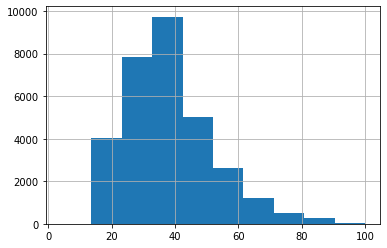

In [34]:
# Tramificacion de edades
age_tram = df[df['pk_partition']=='2018-05-28']['age']
age_tram.hist()

In [35]:
age_divisions = {1:[0,20], 2:[20,40], 3:[40,60], 4:[60,120]}
df['age_tram'] = 0
for div, values in age_divisions.items():
    df['age_tram'] = np.where( (df['age'] > values[0]) & (df['age'] <= values[1]), div, df['age_tram'] )

In [36]:
# Tramificacion de edades
salary_tram = df[df['pk_partition']=='2018-05-28']['salary']
quartiles = salary_tram.describe()
quartiles

count    2.624100e+04
mean     1.180506e+05
std      1.742598e+05
min      7.425000e+03
25%      6.374280e+04
50%      9.170370e+04
75%      1.354172e+05
max      1.326862e+07
Name: salary, dtype: float64

In [37]:
salary_divisions = {1:[0,4e4], 2:[4e4,8e4], 3:[8e4,12e4], 4:[12e4,2e10]}
df['salary'].fillna(-1,inplace=True)

df['salary_tram'] = 0

for div, values in salary_divisions.items():
    print(values)
    df['salary_tram'] = np.where( (df['salary'] > values[0]) & (df['salary'] <= values[1]), div, df['salary_tram'] )

[0, 40000.0]
[40000.0, 80000.0]
[80000.0, 120000.0]
[120000.0, 20000000000.0]


In [38]:
df.fillna(0, inplace=True)

## Feature Generator <a class="anchor" id="16"></a>

[Tabla de Contenidos](#0)

Similarmente a la competición de Time Series con Nico, se implementa una función de Feature Generator donde se generan atributos conjuntos. De esta manera se pueden agrupar comportamientos frente al target, como por ejemplo: los del grupo de edad inferior cuantos productos compraron el mes anterior. El modelo mejora sustancialmente al incorporar estos atributos dado que ayuda a generalizar mejor. 

Se realizan los siguientes grupos de atributos:
- pk_partition, cuentas_fans
- pk_partition, ahorros_fans
- pk_partition, financiacion_fans
- pk_partition, salary_tram
- pk_partition, age_tram
- pk_partition, age_tram ,salary_tram
- total_altas_1m_shift, total_altas_2m_shift, total_altas_3m_shift

In [39]:
def gb_feature_generator(df_, gb_list, target, calculations, filter_positives=False):

    #meses = [1,2,3]
    #gb_list = ['pk_partition','cluster']
    #target = ['altas_shift_1']
    #calculations = ['mean','sum']
   
        
    if filter_positives and df_[df_[target] != 0].shape[0] != 0:
        data = df_[df_[target] != 0]
        gb_df = data.groupby(gb_list)[target].agg(calculations)
    else:
        gb_df = df_.groupby(gb_list)[target].agg(calculations)

    new_cols = []
    for cal in calculations:
        if len(gb_list) == 2:
            new_cols.append(target+'_'+gb_list[1]+'_'+cal)
        elif len(gb_list) == 3:
            new_cols.append(target+'_'+gb_list[1]+'_'+gb_list[2]+'_'+cal)
        #print(new_cols)    
    gb_df.columns = new_cols
    gb_df.reset_index(inplace=True)
    #print(gb_df.head())
    df_ = pd.merge(df_, gb_df, how='left', on=gb_list)
    #df_.drop('index', axis=1, inplace=True)
    
    return df_

In [40]:
df['pk_partition'] = pd.to_datetime(df['pk_partition'])
df['month'] = df['pk_partition'].dt.month
df['year'] = df['pk_partition'].dt.year

In [41]:
print('Initial shape: ',df.shape)

# Per cuentas_fans

gb_list = ['pk_partition', 'cuentas_fans']

feature_list = ['total_altas_3m_shift','total_altas_cuenta_1m_shift','total_altas_cuenta_2m_shift',
    'total_altas_cuenta_3m_shift','total_altas_ahorros_3m_shift','total_altas_financiacion_3m_shift']

df.reset_index(inplace=True)

for key in feature_list:
    lista = gb_list.copy()
    lista.append(key)
    df_ = gb_feature_generator(df[lista], gb_list, key, ['sum','mean'], filter_positives=True)
    for col in df_.columns:
        df[col] = df_[col]

try:
    df.drop('index',axis=1,inplace=True)
except:
    pass

print(gb_list)

print('Final shape: ',df.shape)

Initial shape:  (1386720, 65)
['pk_partition', 'cuentas_fans']
Final shape:  (1386720, 77)


In [42]:
print('Initial shape: ',df.shape)

# Per ahorros_fans

gb_list = ['pk_partition', 'ahorros_fans']

feature_list = ['total_altas_3m_shift','total_altas_cuenta_3m_shift',
 'total_altas_ahorros_1m_shift','total_altas_ahorros_2m_shift',
 'total_altas_ahorros_3m_shift','total_altas_financiacion_3m_shift']

for key in feature_list:
    lista = gb_list.copy()
    lista.append(key)
    df_ = gb_feature_generator(df[lista], gb_list, key, ['sum','mean'], filter_positives=True)
    for col in df_.columns:
        df[col] = df_[col]

try:
    df.drop('index',axis=1,inplace=True)
except:
    pass

print(gb_list)

print('Final shape: ',df.shape)

Initial shape:  (1386720, 77)
['pk_partition', 'ahorros_fans']
Final shape:  (1386720, 89)


In [43]:
print('Initial shape: ',df.shape)

# Per financiacion_fans

gb_list = ['pk_partition', 'financiacion_fans']

feature_list = ['total_altas_3m_shift','total_altas_cuenta_3m_shift',
 'total_altas_ahorros_3m_shift','total_altas_financiacion_1m_shift',
 'total_altas_financiacion_2m_shift','total_altas_financiacion_3m_shift']

for key in feature_list:
    lista = gb_list.copy()
    lista.append(key)
    df_ = gb_feature_generator(df[lista], gb_list, key, ['sum','mean'], filter_positives=True)
    df[df_.columns] = df_

print(gb_list)

print('Final shape: ',df.shape)

Initial shape:  (1386720, 89)
['pk_partition', 'financiacion_fans']
Final shape:  (1386720, 101)


In [44]:
print('Initial shape: ',df.shape)

# Per salary_tram

gb_list = ['pk_partition','salary_tram']

feature_list = ['total_altas_cuenta_3m_shift','total_altas_ahorros_3m_shift','total_altas_financiacion_3m_shift']

for key in feature_list:
    lista = gb_list.copy()
    lista.append(key)
    df_ = gb_feature_generator(df[lista], gb_list, key, ['sum','mean'], filter_positives=True)
    df[df_.columns] = df_

try:
    df.drop('index',axis=1,inplace=True)
except:
    pass

print(gb_list)

print('Final shape: ',df.shape)

Initial shape:  (1386720, 101)
['pk_partition', 'salary_tram']
Final shape:  (1386720, 107)


In [45]:
print('Initial shape: ',df.shape)

# Per age_tram

gb_list = ['pk_partition','age_tram']

feature_list = ['total_altas_cuenta_3m_shift','total_altas_ahorros_3m_shift','total_altas_financiacion_3m_shift']

for key in feature_list:
    lista = gb_list.copy()
    lista.append(key)
    df_ = gb_feature_generator(df[lista], gb_list, key, ['sum','mean'], filter_positives=True)
    df[df_.columns] = df_

try:
    df.drop('index',axis=1,inplace=True)
except:
    pass

print(gb_list)

print('Final shape: ',df.shape)

Initial shape:  (1386720, 107)
['pk_partition', 'age_tram']
Final shape:  (1386720, 113)


In [46]:
print('Initial shape: ',df.shape)

# Per age_tram and salary_tram

gb_list = ['pk_partition','age_tram','salary_tram']

feature_list = ['total_altas_3m_shift']

for key in feature_list:
    lista = gb_list.copy()
    lista.append(key)
    df_ = gb_feature_generator(df[lista], gb_list, key, ['sum','mean'], filter_positives=True)
    df[df_.columns] = df_

try:
    df.drop('index',axis=1,inplace=True)
except:
    pass

print(gb_list)

print('Final shape: ',df.shape)

Initial shape:  (1386720, 113)
['pk_partition', 'age_tram', 'salary_tram']
Final shape:  (1386720, 115)


In [47]:
print('Initial shape: ',df.shape)

# Per fans

gb_list = ['pk_partition','fans']

feature_list = ['total_altas_1m_shift','total_altas_2m_shift','total_altas_3m_shift']

for key in feature_list:
    lista = gb_list.copy()
    lista.append(key)
    df_ = gb_feature_generator(df[lista], gb_list, key, ['sum','mean'], filter_positives=True)
    df[df_.columns] = df_

try:
    df.drop('index',axis=1,inplace=True)
except:
    pass

print(gb_list)

print('Final shape: ',df.shape)

Initial shape:  (1386720, 115)
['pk_partition', 'fans']
Final shape:  (1386720, 121)


In [48]:
del df_, gb_list, feature_list

## Preparación del target <a class="anchor" id="17"></a>

[Tabla de Contenidos](#0)

Como se observa algunos clientes compran varios productos en el mismo mes. El target a predecir será predecir la compra de un tipo de producto por lo que se limitan las compras a 1. 

Y para el caso donde en un mismo mes se producen varias compras, se duplica el número de registros, para así no perder información de cada cliente.

In [49]:
df['compras_cuenta'] = np.where(df['altas_cuenta']>=1,1,0) 
df['compras_ahorros'] =  np.where(df['altas_ahorros']>=1,1,0) 
df['compras_financiacion'] = np.where(df['altas_financiacion']>=1,1,0)

df['compras'] = df['compras_cuenta'] + df['compras_ahorros'] + df['compras_financiacion']
max_ = int(max(df['compras'].value_counts().index)+1)
print(max_)

4


In [50]:
print(df['compras_cuenta'].value_counts())
print(df['compras_ahorros'].value_counts())
print(df['compras_financiacion'].value_counts())

0    1339663
1      47057
Name: compras_cuenta, dtype: int64
0    1349215
1      37505
Name: compras_ahorros, dtype: int64
0    1319471
1      67249
Name: compras_financiacion, dtype: int64


In [51]:
df['compras'].value_counts()

0    1251529
1     119707
2      14348
3       1136
Name: compras, dtype: int64

In [52]:
list_ = list_products.copy()
df['pk_partition'] = pd.to_datetime(df['pk_partition'])
list_.append('pk_partition')
list_.append('pk_cid')

compras_todas = {}

for number in range(1,max_):
    part_df = df[df['compras'] == number][list_].set_index(['pk_cid','pk_partition'])

    #print(part_df[list_products] != 0)
    for key, row in part_df.iterrows():
        #print(key, row[row != 0].index.to_list())
        compras_todas[key] = row[row != 0].index.to_list()     
        
    print(number)
    #for num in range(1,number+1):
    #    df['prod'+str(num)] = np.where( , cost_product[products_dict[prods[num-1]]], df['prod'+str(num)] )

1
2
3


In [53]:
import pickle
f = open("compras_todas.pkl","wb")
pickle.dump(compras_todas,f)
f.close()

In [54]:
compras_df = pd.DataFrame.from_dict(compras_todas, orient='index')

compras_melted = compras_df.melt(ignore_index = False)
compras_melted['tipo_producto'] = compras_melted['value'].replace(products_dict)
compras_melted['precio'] = compras_melted['tipo_producto'].replace(cost_product)
compras_melted = compras_melted.reset_index()

compras_melted['pk_cid'] = compras_melted['index'].apply( lambda x: x[0] )
compras_melted['pk_partition'] = compras_melted['index'].apply( lambda x: x[1] )

#compras_melted = compras_melted[~compras_melted['pk_partition'].isna()]
compras_melted = compras_melted[~compras_melted['tipo_producto'].isna()]

compras_melted

#compras_melted[['pk_cid','pk_partition','tipo_producto','precio']]

,index,variable,value,tipo_producto,precio,pk_cid,pk_partition
0,"(16502, 2019-01-28 00:00:00)",0,emc_account,cuenta,10.0,16502,2019-01-28
1,"(17457, 2018-10-28 00:00:00)",0,em_acount,cuenta,10.0,17457,2018-10-28
2,"(17457, 2019-01-28 00:00:00)",0,long_term_deposit,ahorro e inversión,40.0,17457,2019-01-28
3,"(17457, 2019-03-28 00:00:00)",0,long_term_deposit,ahorro e inversión,40.0,17457,2019-03-28
4,"(17457, 2019-05-28 00:00:00)",0,long_term_deposit,ahorro e inversión,40.0,17457,2019-05-28
...,...,...,...,...,...,...,...
975491,"(1128353, 2018-11-28 00:00:00)",7,debit_card,financiación,60.0,1128353,2018-11-28
986868,"(1190607, 2018-04-28 00:00:00)",7,em_acount,cuenta,10.0,1190607,2018-04-28
1005163,"(1265402, 2018-09-28 00:00:00)",7,debit_card,financiación,60.0,1265402,2018-09-28
1066775,"(1018436, 2018-05-28 00:00:00)",7,em_acount,cuenta,10.0,1018436,2018-05-28


In [55]:
compras_melted.info()
compras_melted['pk_partition'] = compras_melted['pk_partition'].apply(lambda x: str(x)[:11])
df['pk_partition'] = df['pk_partition'].apply(lambda x: str(x)[:11])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311518 entries, 0 to 1069859
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   index          311518 non-null  object        
 1   variable       311518 non-null  int64         
 2   value          311518 non-null  object        
 3   tipo_producto  311518 non-null  object        
 4   precio         311518 non-null  float64       
 5   pk_cid         311518 non-null  int64         
 6   pk_partition   311518 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 19.0+ MB


In [56]:
del compras_todas, compras_df, part_df

In [57]:
df = pd.merge(df, compras_melted[['pk_cid','pk_partition','value','tipo_producto','precio']], on=['pk_cid','pk_partition'], how='left')
del compras_melted

## Precio del producto a comprar <a class="anchor" id="18"></a>

[Tabla de Contenidos](#0)

Existen 14 productos diferentes, éstos pueden ser agrupados en diferentes tipos de productos; y cada tipo tiene un precio. En este apartado se crea una columna nueva que indica la inversión o precio del producto en el que el cliente se dio de alta. 

Sin embargo, aparece el siguiente problema con esta variable, qué precio ponemos aquellos registros donde no hubo ninguna compra, en este caso se opta por rellenar estos registros de manera aleatoria con una distribución equitativa entre 10, 40 y 60 euros. De esta manera se podrá trabajar con un modelo General con todos los productos y en cada registro se supondrá que el cliente deseaba comprar un producto con X precio, de esta manera el modelo tendrá en cuenta cuando un cliente compra o no (teniendo en cuenta el precio del producto y la inversión que supone para él), se espera que ante productos más caros, los clientes sean un poco más reacios a darse de alta. 

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566514 entries, 0 to 1566513
Columns: 128 entries, pk_cid to precio
dtypes: bool(15), float64(61), int64(17), int8(28), object(7)
memory usage: 1.1+ GB


In [59]:
df['precio'].value_counts(dropna=False)

NaN     1254996
10.0     151413
60.0     100008
40.0      60097
Name: precio, dtype: int64

In [60]:
df['precio'] = np.where(df['precio'].isna(),0,df['precio'])
#df['value'] = np.where(df['value'].isna(),0,df['value'])

In [61]:
df['value'].value_counts(dropna=False)

NaN                   1254996
debit_card              85593
em_acount               71227
payroll_account         51558
pension_plan            46029
emc_account             28620
credit_card             14302
long_term_deposit        7062
securities               2600
short_term_deposit       2493
funds                    1913
loans                      83
mortgage                   30
em_account_p                8
Name: value, dtype: int64

In [62]:
df['id'] = range(df.shape[0])

In [63]:
cost_10 = set(list(df['id'].sample(int(df.shape[0]*0.35))))
cost_60 = set(list(df['id'].sample(int(df.shape[0]*0.35))))

print(len(cost_10))
print(len(cost_60))

548279
548279


In [64]:
df['precio'].fillna(0,inplace=True)
df['precio'] = np.where( (df['precio'] == 0) & (df['id'].isin(cost_10)), 10, df['precio'])
df['precio'] = np.where( (df['precio'] == 0) & (df['id'].isin(cost_60)), 60, df['precio'])
df['precio'] = np.where( df['precio'] == 0, 40, df['precio'])

In [65]:
print(df['precio'].value_counts(dropna=False))
df.drop('id',axis=1,inplace=True)

10.0    590738
40.0    590216
60.0    385560
Name: precio, dtype: int64


# Data Cleaning <a class="anchor" id="2"></a>

[Tabla de Contenidos](#0)

El siguiente paso es limpiar el dataset de nulos y quedarse únicamente con las columnas relevantes para el modelo. Muchas de estas columnas no serán introducidas al modelo, pero sería interesante encontrar nuevas métricas y tenerlas en cuenta para así realizar un modelo más complejo y que tenga en cuenta más diversidad de casos. 

In [66]:
df['compras'] = np.where(df['compras']>=1,1,0)

In [67]:
df[['compras','precio']].value_counts()

compras  precio
0        40.0      528625
         10.0      438131
         60.0      284773
1        10.0      152607
         60.0      100787
         40.0       61591
dtype: int64

In [68]:
df.shape

(1566514, 128)

In [69]:
for x in list_products:
    df.drop(x, axis=1, inplace=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566514 entries, 0 to 1566513
Columns: 114 entries, pk_cid to precio
dtypes: bool(1), float64(61), int64(17), int8(28), object(7)
memory usage: 1.0+ GB


In [71]:
remove_cols = ['value','tipo_producto','segment','payroll','country_id','region_code','pk_partition','entry_date','deceased','compra_antes',\
    'total','total_altas','total_altas_cuenta','total_altas_financiacion','total_altas_ahorros','altas_ahorros','altas_cuenta','altas_financiacion']

for col in remove_cols:
    try:
        df.drop(col, axis=1, inplace=True)
    except:
        pass

In [72]:
df.columns.to_list()

['pk_cid',
 'entry_channel',
 'active_customer',
 'gender',
 'age',
 'salary',
 'total_bajas_1m_shift',
 'total_bajas_3m_shift',
 'total_bajas_cuenta_1m_shift',
 'total_bajas_cuenta_3m_shift',
 'total_bajas_ahorros_1m_shift',
 'total_bajas_ahorros_3m_shift',
 'total_bajas_financiacion_1m_shift',
 'total_bajas_financiacion_3m_shift',
 'total_altas_1m_shift',
 'total_altas_2m_shift',
 'total_altas_3m_shift',
 'total_altas_6m_shift',
 'total_altas_cuenta_1m_shift',
 'total_altas_cuenta_2m_shift',
 'total_altas_cuenta_3m_shift',
 'total_altas_cuenta_6m_shift',
 'total_altas_ahorros_1m_shift',
 'total_altas_ahorros_2m_shift',
 'total_altas_ahorros_3m_shift',
 'total_altas_ahorros_6m_shift',
 'total_altas_financiacion_1m_shift',
 'total_altas_financiacion_2m_shift',
 'total_altas_financiacion_3m_shift',
 'total_altas_financiacion_6m_shift',
 'cuentas_fans',
 'ahorros_fans',
 'financiacion_fans',
 'fans',
 'tiempo_ult_compra',
 'age_tram',
 'salary_tram',
 'month',
 'year',
 'total_altas_3m_s

In [73]:
df.isnull().sum()[ df.isnull().sum() != 0 ]

total_altas_cuenta_2m_shift_cuentas_fans_sum          127
total_altas_cuenta_2m_shift_cuentas_fans_mean         127
total_altas_cuenta_3m_shift_cuentas_fans_sum      1371875
total_altas_cuenta_3m_shift_cuentas_fans_mean     1371875
total_altas_ahorros_2m_shift_ahorros_fans_sum         515
total_altas_ahorros_2m_shift_ahorros_fans_mean        515
total_altas_3m_shift_age_tram_salary_tram_sum           5
total_altas_3m_shift_age_tram_salary_tram_mean          5
total_altas_3m_shift_fans_sum                     1188844
total_altas_3m_shift_fans_mean                    1188844
dtype: int64

In [74]:
df.fillna(0,inplace=True)

In [75]:
targets = ['compras','compras_cuenta','compras_ahorros','compras_financiacion']

## Preparación de la predicción <a class="anchor" id="21"></a>

[Tabla de Contenidos](#0)

Para el caso de la predicción (dataset que se introducirá en la tarea 3) se guarda el estado y datos de los clientes en el mes futuro con el objetivo de poder realizar la predicción de las recomendaciones para el próximo mes. 

In [76]:
if PREPARE_PREDICTION:
    prediction_df = df[(df['year']==2019)&(df['month']==5)]
    prediction_df = prediction_df.groupby('pk_cid').last()
    
    prediction_df['tiempo_ult_compra'] += 1
    prediction_df['tiempo_ult_compra'] = np.where(prediction_df['compras']>1, 1, prediction_df['tiempo_ult_compra'])

    prediction_df['month'] += 1

    pred_features = prediction_df.columns.to_list()

    for item in targets+remove_cols:
        try:
            pred_features.remove(item)
        except:
            pass

    prediction_df[pred_features].to_csv(DIR_PATH+'clients_prediction.csv')

    assert 1 != 0 #must finish
                

# Model construction <a class="anchor" id="3"></a>

[Tabla de Contenidos](#0)

En este apartado se construyen 4 modelos diferentes. 
- [Modelo General](#31)
- [Modelo Cuentas](#32)
- [Modelo Ahorros](#33)
- [Modelo Financiación](#34)

Se construye un modelo general donde se tienen en cuenta todas las compras, y también se construyen otros 3 modelos dependiendo del tipo de producto (cuentas, ahorros e inversión o financiación) con el objetivo de ver si dividiendo las compras es posible obtener un mejor score que con un modelo general. 

Más adelante se verá que debido a que el dataset está desbalanceado y que el problema resulta bastante complicado de predecir, los resultados no son tan buenos como se espera. 

Y a continuación se crea una función que permitirá balancear el dataset. El balanceo puede realizarse de dos maneras:
- **Undersampling**. En este caso se aumenta el número de registros de la clase minoritaria.
- **Oversampling** En este caso se reduce el número de registros de la clase mayoritaria, de manera que la distribución no sea tan desproporcionada. 

In [77]:
def balancear_dataset(df, target, dist, totales, tipo, times=1):
    totales_ = totales.copy()
    
    compras = ['compra_ahorros','compra_cuenta','compra_financiacion']
    boolean = False
    if target in compras:
        compras.remove(target)
        boolean = True
    
    subset_positives = df[ (df[target]==True) ]
    df_ = subset_positives.copy(deep=True)
    
    if boolean:
        df = df[(df[compras[0]]==False) & (df[compras[1]]==False)]
    
    if tipo == 'undersampling':
        subset_negatives = df[ (df[target] == 0) ].sample( df_.shape[0]*dist )
    elif tipo == 'oversampling':
        for time in range(times-1):
            df_ = df_.append( subset_positives, ignore_index=True )
        if dist == 0:
            subset_negatives = df[ (df[target] == 0) ]
        else:
            subset_negatives = df[ (df[target] == 0) ].sample( df_.shape[0]*dist )

    df_final = subset_negatives.copy(deep=True)
    df_final = df_final.append( df_, ignore_index=True )
    
    totales_.remove(target)
    #print(totales_)
        
    df_final.drop(totales_, axis='columns', inplace=True)
    
    del totales_
    
    return df_final

In [78]:
def dataset_split(df_final, target, balanceo, totales, dist, times=1):
    features = df_final.columns.to_list()  
    X = df_final[ features ]
    y = df_final[ target ]

    X_validation = X[(X['year']==2019) & (X['month']==5)]
    y_validation = y.loc[X_validation.index]
    
    #X_train_test = X[(X['year']!=2019) & (X['month']!=5)]
    #y_train_test = y.loc[X_train_test.index]
    
    # Balancear dataset 
    df_balanceo = balancear_dataset(df_final, target, dist, totales, "oversampling", times)
    
    features = df_balanceo.columns.to_list()
    remove_cols = ['country_id','compra_antes',target]
    for x in remove_cols:
        try:
            features.remove(x)
        except:
            pass
    
    X_train_test = df_balanceo[ features ]
    y_train_test = df_balanceo[ target ]
    X_validation = X_validation[ features ]
    
    # Train and Test
    X_train, X_test, y_train, y_test =  train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=42)
    
    return X_train, y_train, X_test, y_test, X_validation, y_validation 

También se definen una serie de funciones para visualizar las métricas y la matriz de confusión para un modelo de clasificación como el que estamos tratando:

In [79]:
def metricas(y_test, y_pred, y_test_score, y_train, y_train_pred, y_train_score):
    print("----------- TEST -----------")
    print("Accuracy:",accuracy_score(y_test, y_pred))
    print("Precision:",precision_score(y_test, y_pred))
    print("Recall:",recall_score(y_test, y_pred))
    print("F1-score:",f1_score(y_test, y_pred))
    print("ROC AUC score:",roc_auc_score(y_test, y_test_score))
    print("----------- TRAIN -----------")
    print("Accuracy:",accuracy_score(y_train, y_train_pred))
    print("Precision:",precision_score(y_train, y_train_pred))
    print("Recall:",recall_score(y_train, y_train_pred))
    print("F1-score:",f1_score(y_train, y_train_pred))
    print("ROC AUC score:",roc_auc_score(y_train, y_train_score))

In [80]:
def confusion_matrix_figure(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(8,8))

    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix_ = cf_matrix.copy()
    cf_matrix_[1,1] = cf_matrix[0,0]
    cf_matrix_[0,1] = cf_matrix[1,0]
    cf_matrix_[0,0] = cf_matrix[1,1]
    cf_matrix_[1,0] = cf_matrix[0,1]
    cf_matrix_

    group_names = ['True Pos','False Neg','False Pos','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix_.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix_.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix_, annot=labels, fmt='', cmap='Greens', annot_kws={"size": 20},
                    yticklabels=['Positive','Negative'], xticklabels=['Positive','Negative'])
    ax.set_xlabel('Predicted',fontsize=23)
    ax.set_ylabel('Real',fontsize=23)
    ax.tick_params(labelsize=20)
    
    return fig

## Modelo General <a class="anchor" id="31"></a>

[Tabla de Contenidos](#0)

En este primer modelo, el target a predecir es *compra*, este incluye cualquier compra de cualquier producto o tipo de producto, por lo que el dataset es más rico y está mejor balanceado (por lo que no se balancea). El único inconveniente que presenta este método es la aletoriedad de la variable precio que es la variable que nos permite discernir entre que tipo de producto se compra o no. 

Al tener que rellenar la variable precio en los registros sin compra, la calidad del modelo podría verse afectada. Sin embargo, pese a este hecho este modelo es el que mejor resultados da y los resultados finales son bastante satisfactorios delante del problema al que nos enfrentamos.

In [81]:
df['compras'].value_counts()

0    1251529
1     314985
Name: compras, dtype: int64

In [82]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras', "oversampling", targets, dist=0, times=1)

features = X_train.columns.to_list()
features.remove('pk_cid')
#features.remove('cluster')

In [83]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1253211
0    0.799295
1    0.200705
Name: compras, dtype: float64 

TEST:  313303
0    0.797452
1    0.202548
Name: compras, dtype: float64 

VALIDATION:  175086
0    0.838239
1    0.161761
Name: compras, dtype: float64


Se utiliza un DecisionTreeClassifier para así poder visualizar el árbol de decisión.

In [84]:
#model = lgbm.LGBMClassifier(n_estimators=500, max_depth=20, random_state=42, min_child_samples=250)
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=350, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

In [85]:
metricas(y_test, y_pred, y_test_score, y_train, y_train_pred, y_train_score)

----------- TEST -----------
Accuracy: 0.836040510304721
Precision: 0.6832262366634335
Recall: 0.35520572338045037
F1-score: 0.467408321323781
ROC AUC score: 0.8536905905094356
----------- TRAIN -----------
Accuracy: 0.8399367704241345
Precision: 0.6929499564344433
Recall: 0.36361648497570825
F1-score: 0.47695633241289037
ROC AUC score: 0.8619605332317034


----------- VALIDATION -----------
Accuracy: 0.8746444604365855
Precision: 0.7280990552533638
Recall: 0.35919073511757643
F1-score: 0.4810611434245992
ROC AUC score: 0.8791333445122717


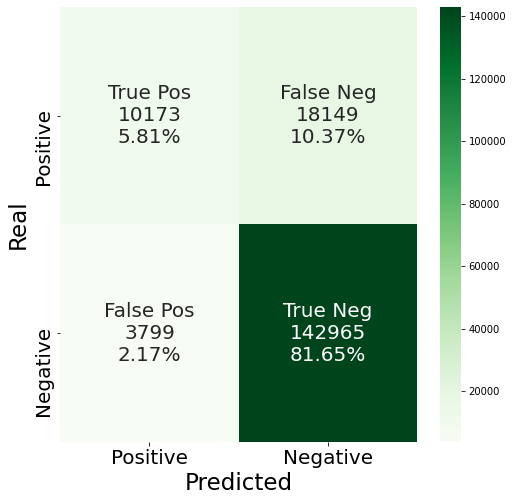

In [86]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

fig = confusion_matrix_figure(y_validation, y_pred_valida)
fig.show()

Y finalmente se evalúa el modelo en validación y se observa la confusion matrix. El ROC AUC score es bastante alto, sin embargo esto se debe al balanceo de los datos, donde falla este modelo es en el bajísimo Recall y la baja precision que tiene y es que al modelo le cuesta predecir positivo y se le escapan muchos casos positivos, y cuando lo hace se equivoca bastante. 

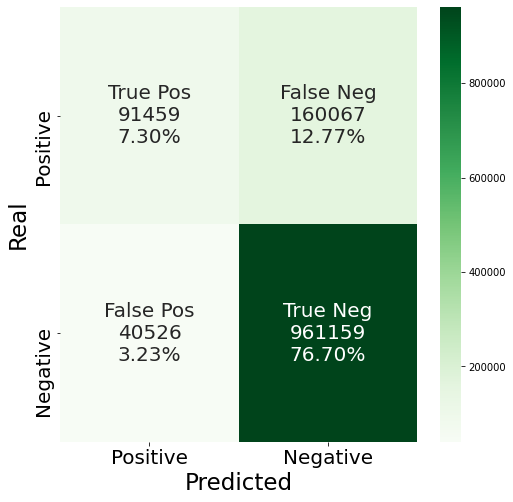

In [87]:
fig = confusion_matrix_figure(y_train, y_train_pred)

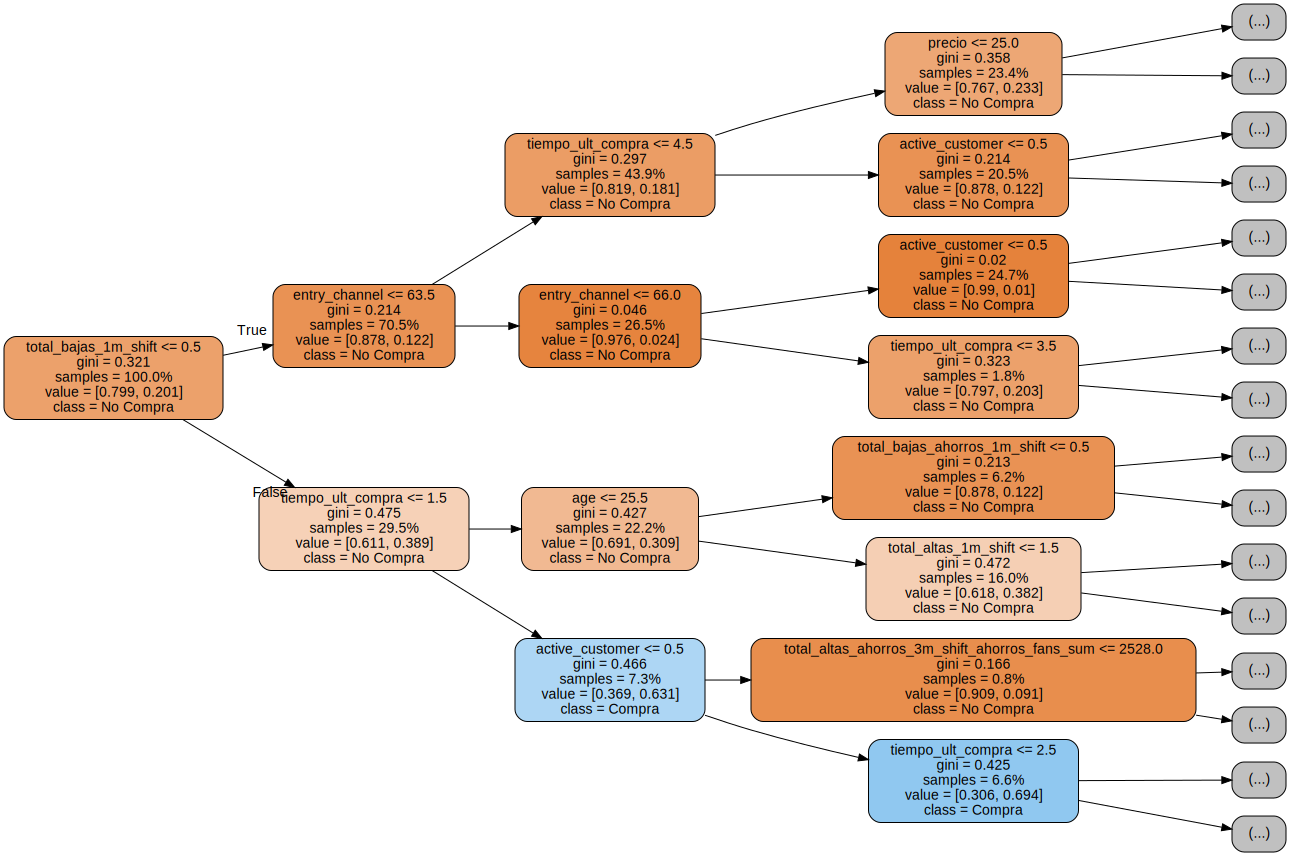

In [88]:
tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

In [89]:
pd.Series( model.feature_importances_, index=features ).sort_values(ascending=False).head(30)

total_bajas_1m_shift                                        0.307558
tiempo_ult_compra                                           0.160709
entry_channel                                               0.136766
precio                                                      0.108458
active_customer                                             0.085732
age                                                         0.078632
total_bajas_ahorros_1m_shift                                0.025057
total_altas_1m_shift                                        0.015266
total_altas_cuenta_1m_shift                                 0.012608
total_altas_ahorros_1m_shift                                0.012247
salary                                                      0.004720
total_bajas_cuenta_1m_shift                                 0.004111
total_altas_financiacion_1m_shift                           0.003643
total_altas_3m_shift_financiacion_fans_mean                 0.003227
total_altas_financiacion_2m_shift_

## Modelo Cuentas <a class="anchor" id="32"></a>

[Tabla de Contenidos](#0)

En este modelo para la predicción de compras en cuentas el target a predecir es *compra_cuenta*. Al reducir el número de compras el dataset está desbalanceado por lo que se balancea. Si el dataset no se balancea, el modelo determinará no compra en todos o casi todos los casos, dado que los casos de compra son minoritarios. 

La idea es aumentar los datos de compra suficientemente ya sea con undersampling o oversampling, de manera que el modelo vea más casos de compra y se "atreva" a predecir compra. 

Sin embargo, los resultados obtenidos son bastante desastrosos y esto se debe a los pocos datos y la poca variedad de compras para el tipo de producto cuenta (siendo este el tipo de producto más comprado, así que resultados peores pueden aparecer en los otros tipos).

In [90]:
df['compras_cuenta'].value_counts()

0    1468495
1      98019
Name: compras_cuenta, dtype: int64

In [91]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras_cuenta', "oversampling", targets, dist=0, times=2)

features = X_train.columns.to_list()
features.remove('pk_cid')
features.remove('precio')
#features.remove('cluster')

In [92]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1331626
0    0.882083
1    0.117917
Name: compras_cuenta, dtype: float64 

TEST:  332907
0    0.882802
1    0.117198
Name: compras_cuenta, dtype: float64 

VALIDATION:  175086
0    0.946278
1    0.053722
Name: compras_cuenta, dtype: float64


In [93]:
#model = lgbm.LGBMClassifier(n_estimators=500, max_depth=20, random_state=42, min_child_samples=250)
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=500, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

----------- VALIDATION -----------
Accuracy: 0.9473915675725072
Precision: 0.5232641374373658
Recall: 0.2331490537954497
F1-score: 0.3225711554019269
ROC AUC score: 0.8634055374775935


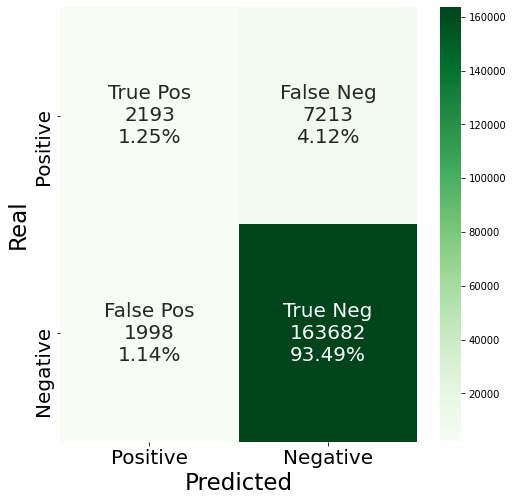

In [94]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

#fig = confusion_matrix_figure(y_train, y_train_pred)
fig = confusion_matrix_figure(y_validation, y_pred_valida)

Los siguientes resultados no son los esperados. Destaca el bajísimo recall y en la confusion matrix evaluada en validación, se observa que pese a que el modelo se atreva a predecir compra, se equivoca más que acierta y aún así se le escapan muchas compras. Se trata de un modelo poco fiable y que no ofrece mucho valor al negocio. 

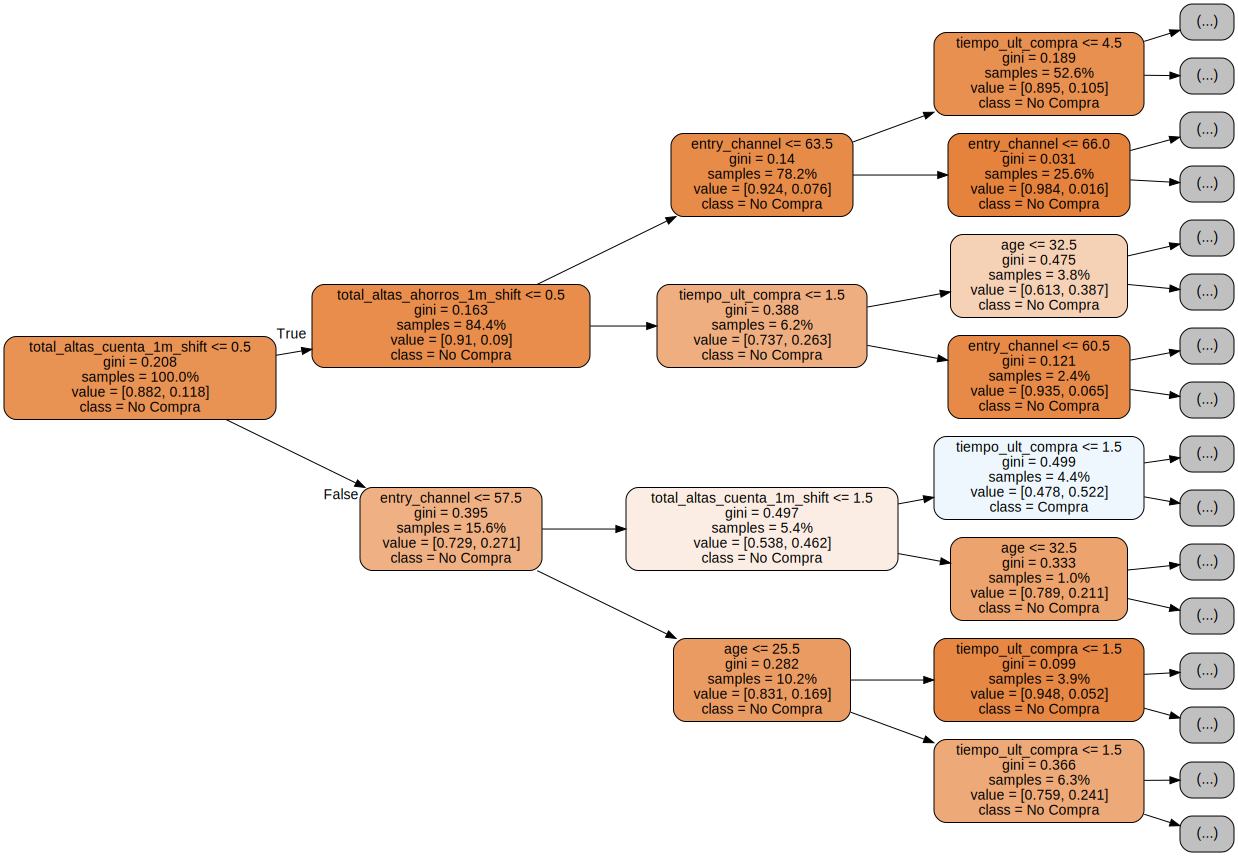

In [95]:
tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

## Modelo Ahorros <a class="anchor" id="33"></a>

[Tabla de Contenidos](#0)

En este caso el caso a predecir es *compra_ahorros*, al igual que en el caso anterior, el dataset se balancea en este caso con un oversampling. Y ocurre más de lo mismo, al modelo le cuesta detectar las compras y cuando lo hace se equivoca demasiado. 

Si se reduce el número de casos positivos (compras) para que el modelo aprenda que las compras son poco frecuentes, entonces predice siempre que no es compra. Aún así mantiene una distribución constante entre el número de predicciones de compra acertadas y erradas.

In [96]:
df['compras_ahorros'].value_counts()

0    1471645
1      94869
Name: compras_ahorros, dtype: int64

In [97]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras_ahorros', "oversampling", targets, dist=0, times=2)

features = X_train.columns.to_list()
features.remove('pk_cid')
features.remove('precio')
#features.remove('cluster')

In [98]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1329106
0    0.885968
1    0.114032
Name: compras_ahorros, dtype: float64 

TEST:  332277
0    0.885105
1    0.114895
Name: compras_ahorros, dtype: float64 

VALIDATION:  175086
0    0.956416
1    0.043584
Name: compras_ahorros, dtype: float64


In [99]:
#model = lgbm.LGBMClassifier(n_estimators=500, max_depth=20, random_state=42, min_child_samples=250)
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=500, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

----------- VALIDATION -----------
Accuracy: 0.9660966610694173
Precision: 0.715703741410028
Recall: 0.3684969204560346
F1-score: 0.48650519031141864
ROC AUC score: 0.8840141320911281


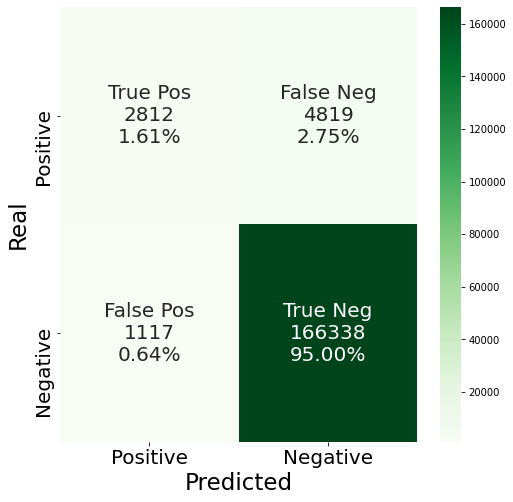

In [100]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

#fig = confusion_matrix_figure(y_train, y_train_pred)
fig = confusion_matrix_figure(y_validation, y_pred_valida)

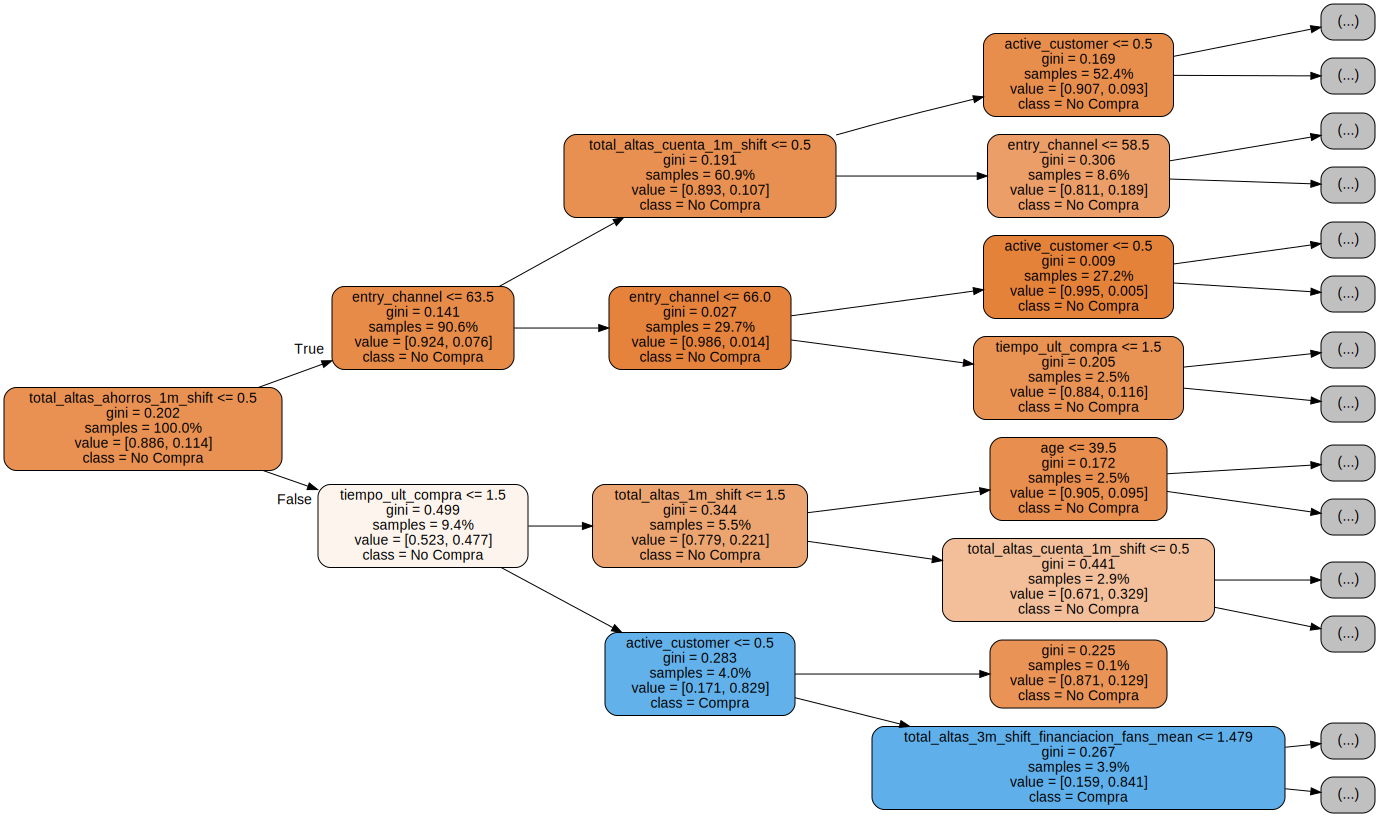

In [101]:
tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

## Modelo Financiación <a class="anchor" id="34"></a>

[Tabla de Contenidos](#0)

El target es *compra_financiacion* y ocurre exactamente lo mismo que con los modelos anteriores, dataset desbalanceado, pocos datos y el modelo no es capaz de encontrar diferencias entre compras y no compras. 

In [102]:
df['compras_financiacion'].value_counts()

0    1400619
1     165895
Name: compras_financiacion, dtype: int64

In [103]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras_financiacion', "oversampling", targets, dist=0, times=2)

features = X_train.columns.to_list()
features.remove('pk_cid')
features.remove('precio')
#features.remove('cluster')

In [104]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1385927
0    0.808464
1    0.191536
Name: compras_financiacion, dtype: float64 

TEST:  346482
0    0.808547
1    0.191453
Name: compras_financiacion, dtype: float64 

VALIDATION:  175086
0    0.91619
1    0.08381
Name: compras_financiacion, dtype: float64


In [105]:
#model = lgbm.LGBMClassifier(n_estimators=550, max_depth=50, random_state=42, min_child_samples=250)
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=500, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

----------- VALIDATION -----------
Accuracy: 0.9252424522805935
Precision: 0.6012262102439647
Recall: 0.32077143246558537
F1-score: 0.4183442207705639
ROC AUC score: 0.8652226938558114


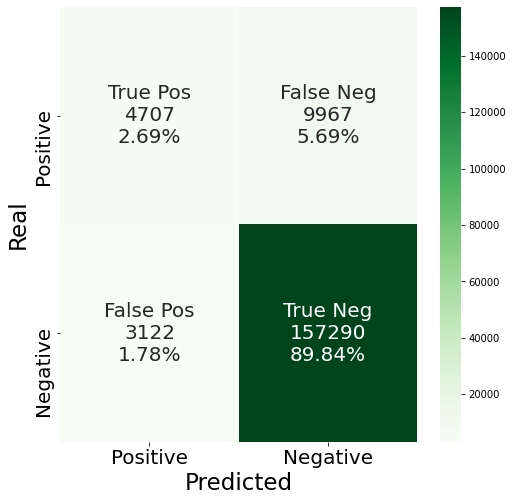

In [106]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

#fig = confusion_matrix_figure(y_train, y_train_pred)
fig = confusion_matrix_figure(y_validation, y_pred_valida)

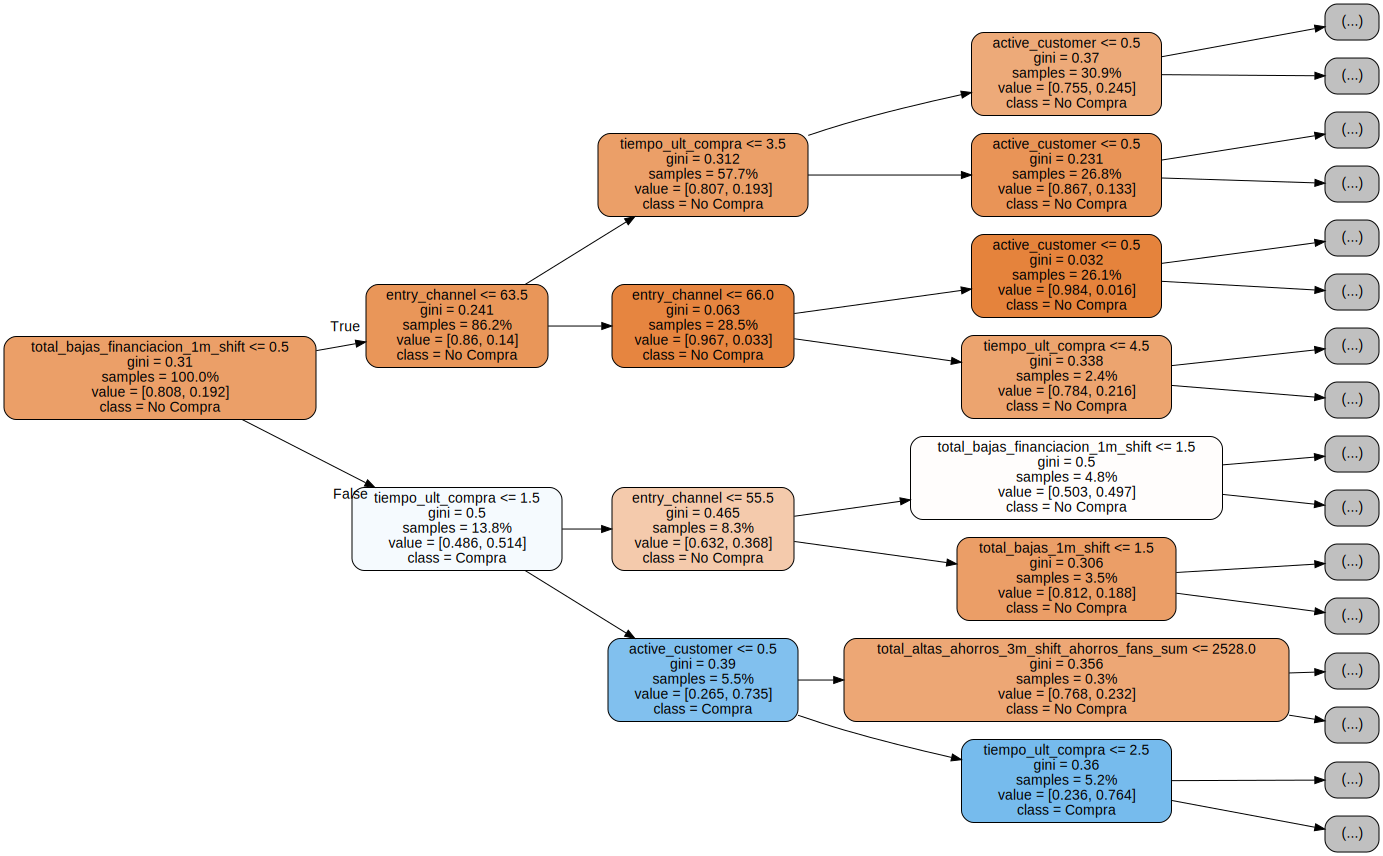

In [107]:
 tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

## Selección del modelo <a class="anchor" id="35"></a>

[Tabla de Contenidos](#0) 

Finalmente, se opta por el [Modelo General](#31) que es el que mejor resultados obtiene.

El valor de Recall es bajo tanto en test, train como en validación. Y deberá prestarse mucha antención con los errores de Tipo II (hipótesis aceptada cuando era falsa - condenar a un inocente). Es decir por la temática del problema donde se cada email tiene un coste, se prefiere reducir el número de emails a clientes que no tenían ningún deseo a comprar. 

Finalmente, guardamos el modelo que será utilizado en la Tarea de Recomendación. 

In [108]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras', "oversampling", targets, dist=0, times=1)

features = X_train.columns.to_list()
features.remove('pk_cid')
#features.remove('cluster')

In [109]:
X_train.columns.to_list()

['pk_cid',
 'entry_channel',
 'active_customer',
 'gender',
 'age',
 'salary',
 'total_bajas_1m_shift',
 'total_bajas_3m_shift',
 'total_bajas_cuenta_1m_shift',
 'total_bajas_cuenta_3m_shift',
 'total_bajas_ahorros_1m_shift',
 'total_bajas_ahorros_3m_shift',
 'total_bajas_financiacion_1m_shift',
 'total_bajas_financiacion_3m_shift',
 'total_altas_1m_shift',
 'total_altas_2m_shift',
 'total_altas_3m_shift',
 'total_altas_6m_shift',
 'total_altas_cuenta_1m_shift',
 'total_altas_cuenta_2m_shift',
 'total_altas_cuenta_3m_shift',
 'total_altas_cuenta_6m_shift',
 'total_altas_ahorros_1m_shift',
 'total_altas_ahorros_2m_shift',
 'total_altas_ahorros_3m_shift',
 'total_altas_ahorros_6m_shift',
 'total_altas_financiacion_1m_shift',
 'total_altas_financiacion_2m_shift',
 'total_altas_financiacion_3m_shift',
 'total_altas_financiacion_6m_shift',
 'cuentas_fans',
 'ahorros_fans',
 'financiacion_fans',
 'fans',
 'tiempo_ult_compra',
 'age_tram',
 'salary_tram',
 'month',
 'year',
 'total_altas_3m_s

In [110]:
model = lgbm.LGBMClassifier(n_estimators=550, max_depth=50, random_state=42, min_child_samples=250)
#model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=500, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

----------- VALIDATION -----------
Accuracy: 0.8772032029973842
Precision: 0.7535682426404996
Recall: 0.35791963844361274
F1-score: 0.48532580073730075
ROC AUC score: 0.8867631507117257


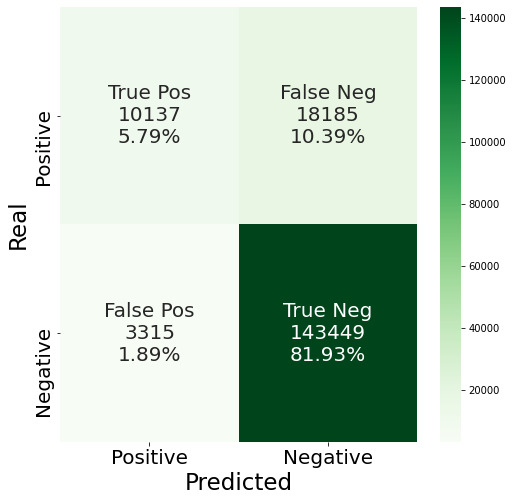

In [111]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

fig = confusion_matrix_figure(y_validation, y_pred_valida)
fig.show()

In [112]:
pd.Series( model.feature_importances_, index=features ).sort_values(ascending=False).head(30)

age                                                    1760
salary                                                 1630
entry_channel                                          1314
tiempo_ult_compra                                      1208
total_altas_3m_shift_age_tram_salary_tram_mean          502
total_altas_6m_shift                                    498
total_bajas_1m_shift                                    427
total_altas_3m_shift_age_tram_salary_tram_sum           423
precio                                                  423
total_altas_cuenta_6m_shift                             367
total_altas_financiacion_6m_shift                       340
total_bajas_cuenta_1m_shift                             330
total_altas_ahorros_3m_shift_salary_tram_mean           315
total_bajas_ahorros_1m_shift                            293
total_altas_financiacion_3m_shift_salary_tram_mean      281
gender                                                  261
total_bajas_financiacion_1m_shift       

Guardamos el modelo en un pickle para así poder utilizarlo en otro script o notebook.

In [113]:
import pickle 

filename = 'modelo_compra_general.sav'
pickle.dump(model, open(filename, 'wb'))

Vamos a evaluar las características de los errores de tipo II que suele cometer el modelo. Lo que destaca en este caso es la alta probabilidad que aparece en los errores de tipo II.

In [114]:
summary = X_train.copy(deep=True)
summary['real'] = y_train
summary['predicted'] = y_train_pred
summary['proba'] = y_train_score
summary['diff'] = summary['predicted']-summary['real']

summary[summary['diff'] == 1].describe()

,pk_cid,entry_channel,active_customer,gender,age,salary,total_bajas_1m_shift,total_bajas_3m_shift,total_bajas_cuenta_1m_shift,total_bajas_cuenta_3m_shift,...,total_altas_1m_shift_fans_mean,total_altas_2m_shift_fans_sum,total_altas_2m_shift_fans_mean,total_altas_3m_shift_fans_sum,total_altas_3m_shift_fans_mean,precio,real,predicted,proba,diff
count,3.466600e+04,34666.000000,34666.000000,34666.000000,34666.000000,3.466600e+04,34666.000000,34666.000000,34666.000000,34666.000000,...,34666.000000,34666.000000,34666.000000,34666.000000,34666.000000,34666.000000,34666.0,34666.0,34666.000000,34666.0
mean,1.234643e+06,47.774505,0.998644,0.576761,37.228062,9.456017e+04,1.251370,0.188456,0.390729,0.082242,...,1.180673,9294.303958,1.487167,3215.055588,0.367118,30.674148,0.0,1.0,0.638229,1.0
std,1.824147e+05,14.933174,0.036797,0.494080,11.933704,1.332781e+05,0.563815,0.614217,0.551059,0.343430,...,0.053035,11180.813090,0.089602,6642.344007,0.788526,22.935291,0.0,0.0,0.107759,0.0
min,1.650200e+04,1.000000,0.000000,0.000000,20.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.087253,47.000000,1.167950,0.000000,0.000000,10.000000,0.0,1.0,0.500000,1.0
25%,1.123130e+06,45.000000,1.000000,0.000000,29.000000,3.820278e+04,1.000000,0.000000,0.000000,0.000000,...,1.156239,1719.000000,1.480822,0.000000,0.000000,10.000000,0.0,1.0,0.539228,1.0
50%,1.248614e+06,45.000000,1.000000,1.000000,35.000000,7.783315e+04,1.000000,0.000000,0.000000,0.000000,...,1.169465,5471.000000,1.516841,0.000000,0.000000,10.000000,0.0,1.0,0.617566,1.0
75%,1.376286e+06,59.000000,1.000000,1.000000,44.000000,1.247082e+05,1.000000,0.000000,1.000000,0.000000,...,1.207757,10231.000000,1.531206,0.000000,0.000000,60.000000,0.0,1.0,0.725201,1.0
max,1.548133e+06,68.000000,1.000000,1.000000,101.000000,1.326862e+07,6.000000,8.000000,3.000000,4.000000,...,1.317170,37476.000000,1.628571,22301.000000,3.567625,60.000000,0.0,1.0,0.978108,1.0


In [115]:
summary[summary['diff'] == 1].sort_values('proba',ascending=False).head(30)

,pk_cid,entry_channel,active_customer,gender,age,salary,total_bajas_1m_shift,total_bajas_3m_shift,total_bajas_cuenta_1m_shift,total_bajas_cuenta_3m_shift,...,total_altas_1m_shift_fans_mean,total_altas_2m_shift_fans_sum,total_altas_2m_shift_fans_mean,total_altas_3m_shift_fans_sum,total_altas_3m_shift_fans_mean,precio,real,predicted,proba,diff
169058,1135369,45,1.0,1,64,-1.00,1,0,0,0,...,1.169465,10231.0,1.480822,0.0,0.000000,10.0,0,1,0.978108,1
177014,1138594,44,1.0,1,66,-1.00,1,0,0,0,...,1.169465,10231.0,1.480822,0.0,0.000000,10.0,0,1,0.977370,1
336248,1264562,45,1.0,0,79,-1.00,1,0,0,0,...,1.178798,1858.0,1.461841,20301.0,1.000000,40.0,0,1,0.969141,1
218886,1181419,45,1.0,1,87,-1.00,1,0,0,0,...,1.207757,2246.0,1.553250,0.0,0.000000,40.0,0,1,0.968426,1
150784,1123934,17,1.0,1,62,65347.74,1,0,0,0,...,1.207757,2246.0,1.553250,0.0,0.000000,40.0,0,1,0.968191,1
400359,1315624,45,1.0,1,67,101559.00,1,1,0,1,...,1.169465,10231.0,1.480822,0.0,0.000000,40.0,0,1,0.960910,1
333457,1263496,67,1.0,1,62,43191.60,1,0,0,0,...,1.169465,10231.0,1.480822,0.0,0.000000,10.0,0,1,0.958653,1
32359,1008717,44,1.0,1,64,187228.53,1,0,0,0,...,1.169465,10231.0,1.480822,0.0,0.000000,10.0,0,1,0.958225,1
77423,1053126,17,1.0,1,67,61660.41,1,0,0,0,...,1.198049,449.0,1.532423,5443.0,1.000000,10.0,0,1,0.958119,1
172458,1136733,17,1.0,1,73,116504.04,1,0,0,0,...,1.198049,449.0,1.532423,5443.0,1.000000,60.0,0,1,0.956864,1


# Conclusiones <a class="anchor" id="4"></a>

[Tabla de Contenidos](#0) 

Esta tarea ha resultado ser la más compleja de todas sin ninguna duda, la creación del modelo de Compra ha sido complicada. En un principio se utilizó variables como el *cluster* de la Tarea 2, variables que enmascaraban información de los clientes en el futuro; lo que se conoce como Data Leakage, aun así el modelo tampoco tenía un score aceptable; sin embargo se observó que añadirla mejoraba el modelo.

Esto se debe a que en modelos en lugar de trabajar únicamente con datos de registros particulares, poder obtener atributos del comportamiento pasado de un grupo (ya sea clientes de la misma edad, clientes que han comprado anteriormente varios productos de financiación...) ayudan al modelo y le permiten generalizar mejor. Este planteamiento viene totalmente inspirado de la competición de Kaggle de Time Series con Nico, es por ello que muchas de estos atributos tienen un factor de Time Series. 

Es importante destacar que el problema se evalúa de forma estacionaria, es decir se pretende que el modelo aprenda que razones, combinación de atributos, estados, etc. hacen que compre o no compre. (En el árbol de decisión puede observarse qué atributos son los que impulsan a un cliente a decidir comprar o no). Y la validación se realiza para el último mes.

Finalmente, se puede afirmar que el modelo implementado es satisfactorio aunque tiene bastante margen de mejora, aunque necesitaría un estudio mucho más exhaustivo (más aún del que se le ha hecho).